# Analysis on whatsapp chats , (without media)

Replace the path of your exported chat.

## Loading the data and printing the total lines

In [1]:
file_path="/Users/amuthanmannan/Downloads/data-ana-chats/WhatsApp Chat with Anand EIE.txt"
with open(file_path) as f:
    lines = f.readlines()

In [2]:
len(lines)

2674

## Just sample one of the data lines

In [3]:
lines[1]

'9/4/19, 16:44 - Anand EIE: Bro,???\n'

## Defining utility method for recoginze timestamp string

You may need to replace the timestamp pattern , based on your whatsapp configuration at the time of export.

In [4]:
import re
timestamp_pattern = '^\d{1,2}\/\d{1,2}\/\d{2},\ \d{1,2}\:\d{1,2}'
pattern_with_hyphen_and_space = timestamp_pattern+'\ \-'
#To Ignore hyphen and space at end of timestamp (9/4/19, 16:44 - )

def startsWithDate(s):
    result = re.match(pattern_with_hyphen_and_space, s)
    if result:
        p=re.compile(timestamp_pattern)
        matched=p.search(s)
        return True,matched.group(0)
    return False,""

## Extracting messages, timestring, and add the lines that don't have timestamp to the previous message string

So there is no surity that each line represents new message. If there is multiline messages in conversation ,they won't have timesatamp and the structure we see above . So they are continuation of previous message only , we are appending them

In [5]:
date_times=[]
messages=[]
i=0
while i < len(lines):
    msg=lines[i]
    is_start_with_date, datetime=startsWithDate(msg)
    if is_start_with_date:
        date_times.append(datetime)
        messages.append(re.compile(pattern_with_hyphen_and_space).split(msg)[1])
    else:
        messages[-1]+=str(msg)
    i=i+1

In [6]:
len(messages)

2593

## Split sender name from message string and ignore the lines that don't have sender names.

Even if there are timestamps, there are some possibilities that they aren't messages. Example, group name change, below lines at the start of convo,  "Messages and calls are end-to-end encrypted..." . These things are done by whatsapp itself , they are not messages. So we will ignore them.

In [7]:
j=0
sender=[]
real_messages=[]
real_date_times=[]
while j < len(messages):
    msg=messages[j]
    splitted=msg.split(":")
    if len(splitted) > 1:
        sender.append(splitted[0])
        real_messages.append(splitted[1])
        real_date_times.append(date_times[j])
    j=j+1    

In [8]:
len(real_messages),len(sender),len(real_date_times)

(2592, 2592, 2592)

## Converting to numpy array and fill the boring dates (days with no messages) with empty messages

In [9]:
import numpy as np
from datetime import datetime, timedelta
array=[]
prev_date=None
for i in range(len(real_messages)):
    current_date=datetime.strptime(real_date_times[i], "%m/%d/%y, %H:%M")
    if i==0:
        array.append([current_date,sender[i].strip(),real_messages[i].lower().strip(),current_date.date()])
        prev_date=current_date
    missed_days=(current_date-prev_date).days    
    if missed_days == 0:    
        array.append([current_date,sender[i].strip(),real_messages[i].lower().strip(),current_date.date()])
    elif missed_days > 0:
        for j in range(missed_days):
            array.append([prev_date+timedelta(days=j+1),"","",prev_date.date()+timedelta(days=j+1)])
        array.append([current_date,sender[i].strip(),real_messages[i].lower().strip(),current_date.date()])
    prev_date=current_date

np_array=np.array(array)

In [10]:
np_array.size

12632

## Constructing data frame 

In [11]:
column_values = ['date_time', 'sender','message','date']

In [12]:
import pandas as pd
df = pd.DataFrame(data = np_array,
                  columns = column_values)
df=df.set_index('date_time')
df

,sender,message,date
date_time,,,
2019-09-04 16:44:00,Anand EIE,"bro,???",2019-09-04
2019-09-04 16:44:00,Anand EIE,"bro,???",2019-09-04
2019-09-04 16:44:00,Amuthan Mannan,sollunga,2019-09-04
2019-09-04 16:45:00,Anand EIE,where are you,2019-09-04
2019-09-04 16:45:00,Amuthan Mannan,dept da,2019-09-04
...,...,...,...
2021-08-10 10:31:00,Anand EIE,okay okay bruh,2021-08-10
2021-08-11 10:31:00,,,2021-08-11
2021-08-12 10:31:00,,,2021-08-12


In [13]:
df['sender'].replace('', np.nan, inplace=True) # Filling empty cells with Nan

In [14]:
df

,sender,message,date
date_time,,,
2019-09-04 16:44:00,Anand EIE,"bro,???",2019-09-04
2019-09-04 16:44:00,Anand EIE,"bro,???",2019-09-04
2019-09-04 16:44:00,Amuthan Mannan,sollunga,2019-09-04
2019-09-04 16:45:00,Anand EIE,where are you,2019-09-04
2019-09-04 16:45:00,Amuthan Mannan,dept da,2019-09-04
...,...,...,...
2021-08-10 10:31:00,Anand EIE,okay okay bruh,2021-08-10
2021-08-11 10:31:00,NaN,,2021-08-11
2021-08-12 10:31:00,NaN,,2021-08-12


## Seeing the message count by name

In [15]:
df['sender'].replace('', np.nan, inplace=True)
df.groupby('sender').size()

sender
Amuthan Mannan    1104
Anand EIE         1489
dtype: int64

## Plot the message count by date 

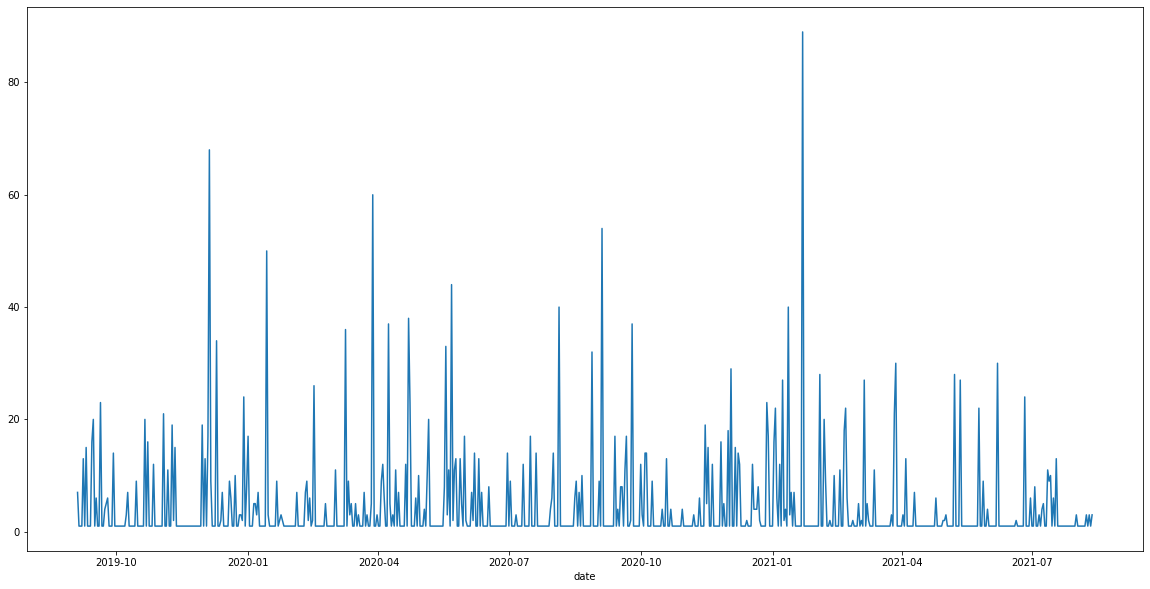

In [26]:
df_grouped=df.groupby('date').size()
df_grouped.plot(kind='line')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

## Zooming more into dates

Since the timestamps are index , we can directly go into index slicing

<AxesSubplot:xlabel='date'>

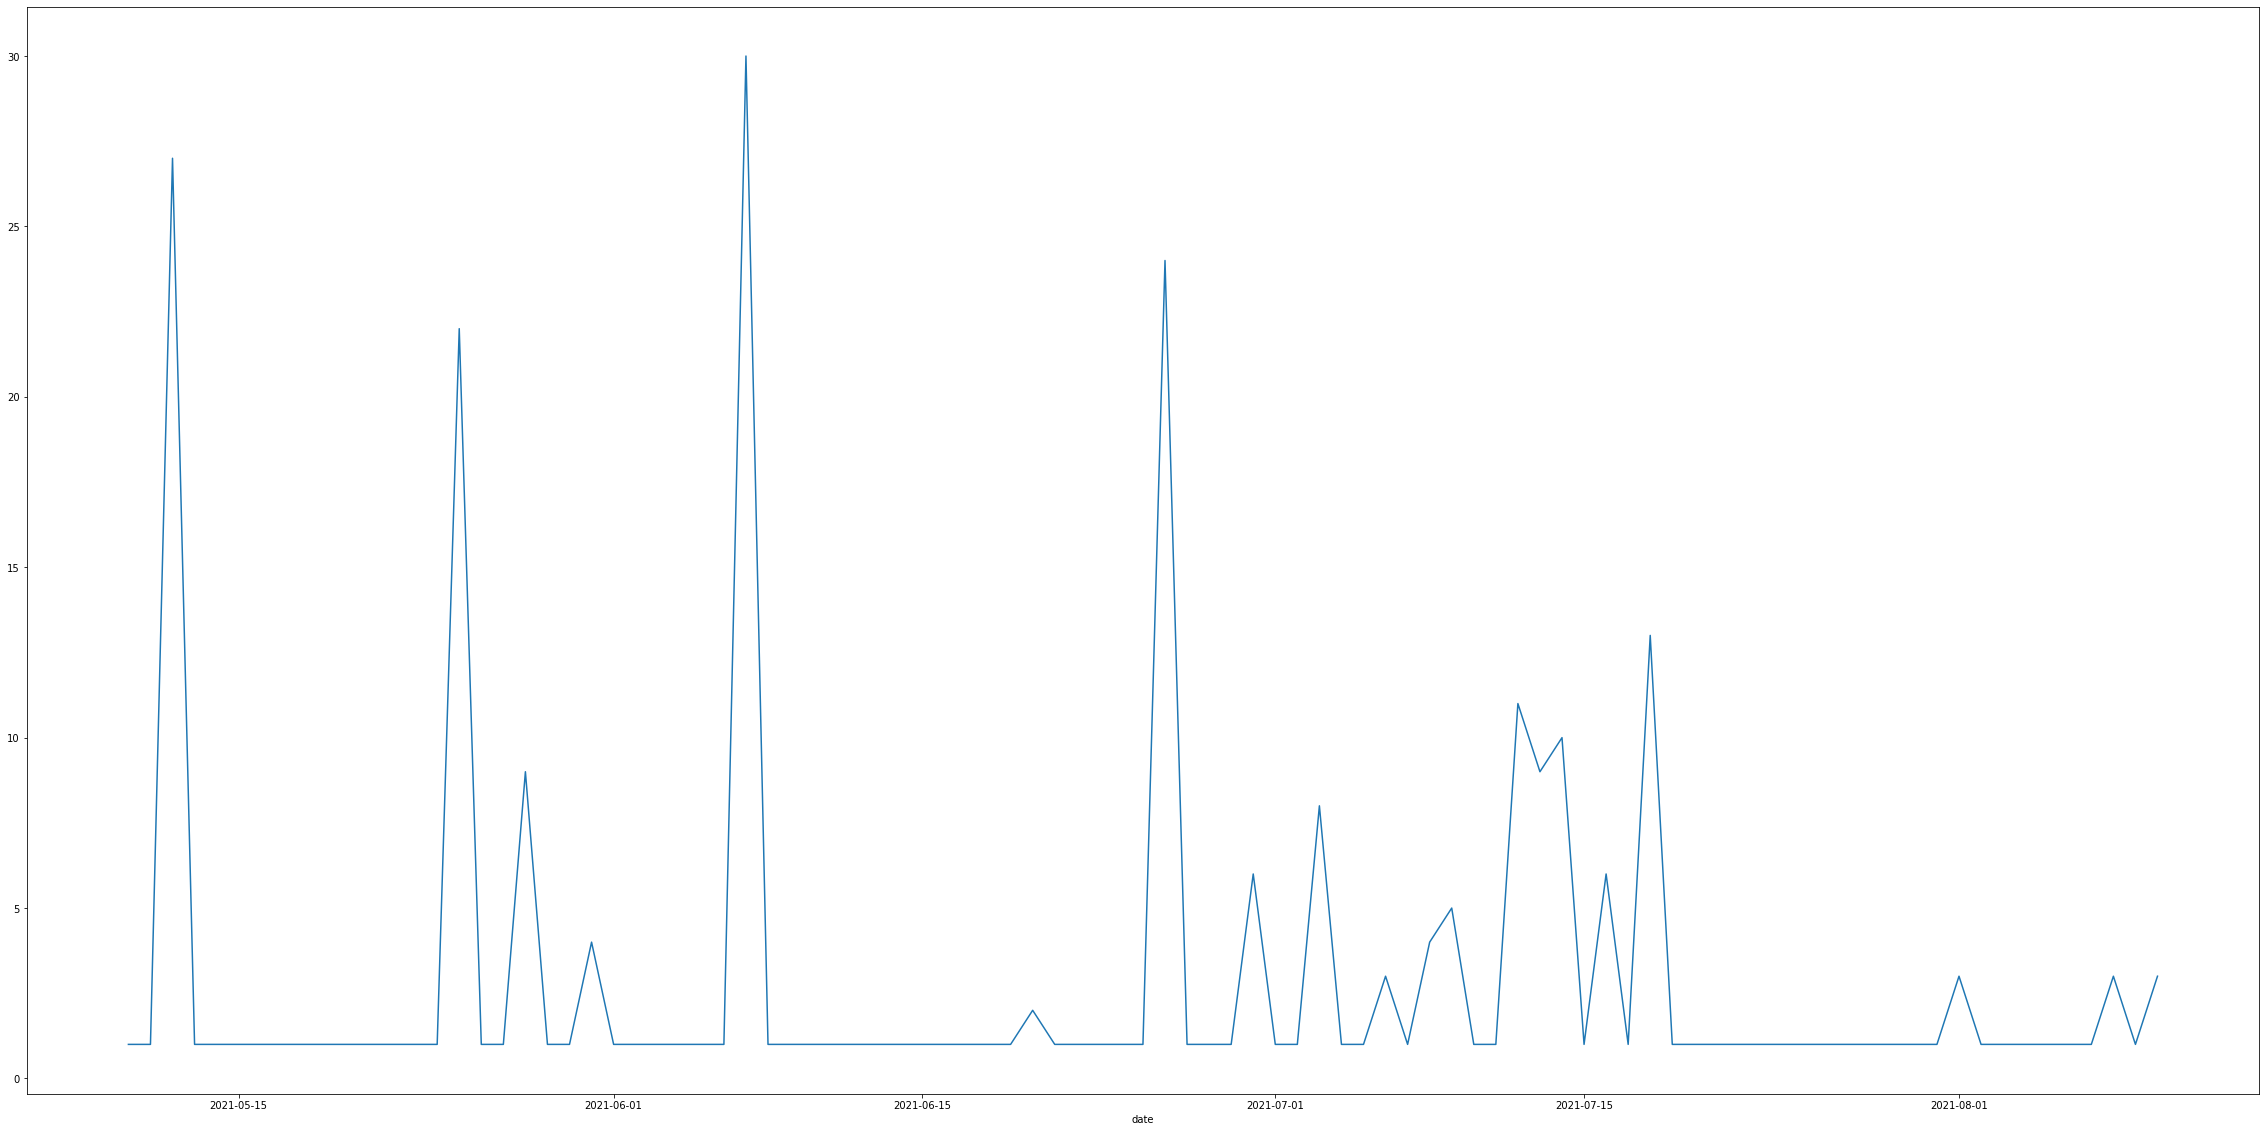

In [17]:

df['2021-05-10' : '2021-08-10'].groupby('date').size().plot()

## Utility to get list of words

In [18]:
def get_list_of_words_from_coloumn(df,coloumn,words_to_ignore):
    listt=" ".join(df[coloumn]).replace("\n","").replace("/ +"," ").split(' ')
    words=[]
    for item in listt:
        if len(item) != 0 and not [y for y in words_to_ignore if item in y]:
            words.append(item)
    return words        

## Extract words from message and sorting 

Omitted media files , will existed as "<media/ omitted>" and we can ignore those kind of whatsapp label messages.
I don;t want to print all messages , :) just print some.

In [19]:
from collections import Counter
counts = Counter(get_list_of_words_from_coloumn(df,'message',['omitted>','<media']))
print(counts.most_common(30))

[('da', 185), ('la', 101), ('https', 73), ('bro', 73), ('ok', 71), ('mm', 68), ('aama', 52), ('nu', 48), ('😂😂', 45), ('dei', 40), ('tha', 40), ('ama', 40), ('😂', 37), ('ena', 34), ('mmm', 32), ('ah', 31), ('antha', 29), ('thaan', 29), ('oru', 29), ('uh', 28), ('oo', 26), ('haan', 25), ('ithu', 24), ('nee', 23), ('intha', 23), ('illa', 22), ('nalla', 22), ('this', 21), ('iruku', 19), ('athu', 18)]


## Same above task for individual senders

Replace the sender names

In [20]:
ananth_df = df[df.sender == 'Anand EIE']
from collections import Counter
counts = Counter(get_list_of_words_from_coloumn(ananth_df,'message',['omitted>','<media']))
print(counts.most_common(30))

[('la', 80), ('bro', 64), ('mm', 62), ('da', 58), ('https', 43), ('nu', 42), ('ok', 39), ('ama', 39), ('tha', 38), ('ena', 34), ('😂', 32), ('uh', 27), ('😂😂', 25), ('iruku', 19), ('oru', 18), ('hmm', 17), ('amutha', 17), ('ne', 17), ('🤣🤣', 17), ('ila', 16), ('nalla', 16), ('movie', 15), ('ithu', 14), ('😅', 13), ('lam', 13), ('this', 12), ('iruka', 12), ('antha', 12), ('macha', 11), ('call', 11)]


In [21]:
am_df = df[df.sender == 'Amuthan Mannan']
from collections import Counter
counts = Counter(get_list_of_words_from_coloumn(am_df,'message',['omitted>','<media']))
print(counts.most_common(30))

[('da', 127), ('aama', 52), ('dei', 40), ('ok', 32), ('ah', 31), ('https', 30), ('thaan', 28), ('oo', 26), ('mmm', 24), ('la', 21), ('illa', 21), ('😂😂', 20), ('haan', 20), ('antha', 17), ('nee', 16), ('enna', 15), ('intha', 15), ('pa', 14), ('😂😂😂', 13), ('naa', 12), ('maathiri', 12), ('sari', 11), ('oru', 11), ('oh', 10), ('athu', 10), ('ipo', 10), ('time', 10), ('ennada', 10), ('ithu', 10), ('this', 9)]


## Sorting the dates based on message count to get peak days

In [22]:
df_sorted_by_date=df.drop(['sender'],axis=1).groupby('date').count().sort_values(by='message',ascending=False)
df_sorted_by_date.head(5)

,message
date,
2021-01-22,89
2019-12-05,68
2020-03-28,60
2020-09-04,54
2020-01-14,50
